<p><span style="color: #ff0000;">This notebook demonstrates how to do timeseries forecasting using recurrent layers</span></p>

<p><span style="color: #ffcc99;">This example requires TensorFlow 2.03 or higher</span></p>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
tf. __version__

'2.12.0'

## Climate Data Time-Series

We will be using Jena Climate dataset recorded by the
[Max Planck Institute for Biogeochemistry](https://www.bgc-jena.mpg.de/wetter/).
The dataset consists of 14 features such as temperature, pressure, humidity etc, recorded once per
10 minutes.

**Location**: Weather Station, Max Planck Institute for Biogeochemistry
in Jena, Germany

**Time-frame Considered**: Jan 10, 2009 - December 31, 2016


The table below shows the column names, their value formats, and their description.

Index| Features      |Format             |Description
-----|---------------|-------------------|-----------------------
1    |Date Time      |01.01.2009 00:10:00|Date-time reference
2    |p (mbar)       |996.52             |The pascal SI derived unit of pressure used to quantify internal pressure. Meteorological reports typically state atmospheric pressure in millibars.
3    |T (degC)       |-8.02              |Temperature in Celsius
4    |Tpot (K)       |265.4              |Temperature in Kelvin
5    |Tdew (degC)    |-8.9               |Temperature in Celsius relative to humidity. Dew Point is a measure of the absolute amount of water in the air, the DP is the temperature at which the air cannot hold all the moisture in it and water condenses.
6    |rh (%)         |93.3               |Relative Humidity is a measure of how saturated the air is with water vapor, the %RH determines the amount of water contained within collection objects.
7    |VPmax (mbar)   |3.33               |Saturation vapor pressure
8    |VPact (mbar)   |3.11               |Vapor pressure
9    |VPdef (mbar)   |0.22               |Vapor pressure deficit
10   |sh (g/kg)      |1.94               |Specific humidity
11   |H2OC (mmol/mol)|3.12               |Water vapor concentration
12   |rho (g/m ** 3) |1307.75            |Airtight
13   |wv (m/s)       |1.03               |Wind speed
14   |max. wv (m/s)  |1.75               |Maximum wind speed
15   |wd (deg)       |152.3              |Wind direction in degrees

In [3]:
# from zipfile import ZipFile
# import os

# uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
# zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
# zip_file = ZipFile(zip_path)
# zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path)    

In [4]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


<div>
<h3><span style="color: #ffff99;">&nbsp;Raw Data Visualization</span></h3>
<div><span style="color: #ffff99;">To give us a sense of the data we are working with, each feature has been plotted below.</span></div>
<div><span style="color: #ffff99;">This shows the distinct pattern of each feature over the time period from 2009 to 2016.</span></div>
<div><span style="color: #ffff99;">It also shows where anomalies are present, which will be addressed during normalization.</span></div>
</div>

<h3><span style="color: #ffff99;">dpi,facecolor,edgecolor(additional keyword arguments which are passed to the&nbsp;<a class="reference internal" title="matplotlib.pyplot.figure" href="https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.figure.html#matplotlib.pyplot.figure"><code class="xref py py-obj docutils literal notranslate"><span class="pre">pyplot.figure</span></code></a>&nbsp;call.)</span></h3>
<div><span style="color: #99ccff;"><strong>dpi:</strong><span class="classifier">float, default:&nbsp;<code class="docutils literal notranslate"><a class="reference internal" style="color: #99ccff;" href="https://matplotlib.org/stable/tutorials/introductory/customizing.html?highlight=figure.dpi#matplotlibrc-sample"><span class="std std-ref"><span class="pre">rcParams["figure.dpi"]</span></span></a></code>&nbsp;(default:&nbsp;<code class="docutils literal notranslate"><span class="pre">100.0</span></code>)</span></span>
<p><span style="color: #99ccff;">The resolution of the figure in dots-per-inch</span></p>
<span style="color: #99ccff;"><strong>facecolor:</strong><span class="classifier">color, default:&nbsp;<code class="docutils literal notranslate"><a class="reference internal" style="color: #99ccff;" href="https://matplotlib.org/stable/tutorials/introductory/customizing.html?highlight=figure.facecolor#matplotlibrc-sample"><span class="std std-ref"><span class="pre">rcParams["figure.facecolor"]</span></span></a></code>&nbsp;(default:&nbsp;<code class="docutils literal notranslate"><span class="pre">'white'</span></code>)</span></span>
<p><span style="color: #99ccff;">The background color.</span></p>
<span style="color: #99ccff;"><strong>edgecolor:</strong><span class="classifier">color, default:&nbsp;<code class="docutils literal notranslate"><a class="reference internal" style="color: #99ccff;" href="https://matplotlib.org/stable/tutorials/introductory/customizing.html?highlight=figure.edgecolor#matplotlibrc-sample"><span class="std std-ref"><span class="pre">rcParams["figure.edgecolor"]</span></span></a></code>&nbsp;(default:&nbsp;<code class="docutils literal notranslate"><span class="pre">'white'</span></code>)</span></span>
<p><span style="color: #99ccff;">The border color.</span></p>
</div>

C:\Users\Mahdi\AppData\Local\Temp\ipykernel_2500\3637785649.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


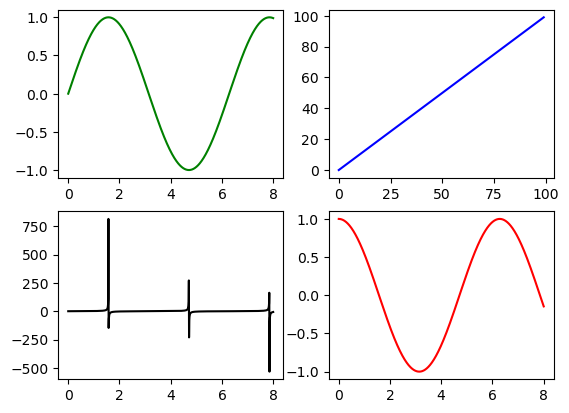

In [5]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(2, 2)
x = np.linspace(0, 8, 1000)

ax[0, 0].plot(x, np.sin(x), 'g') #row=0, col=0
ax[1, 0].plot(x, np.tan(x), 'k') #row=1, col=0
ax[0, 1].plot(range(100), 'b') #row=0, col=1
ax[1, 1].plot(x, np.cos(x), 'r') #row=1, col=1
fig.show()

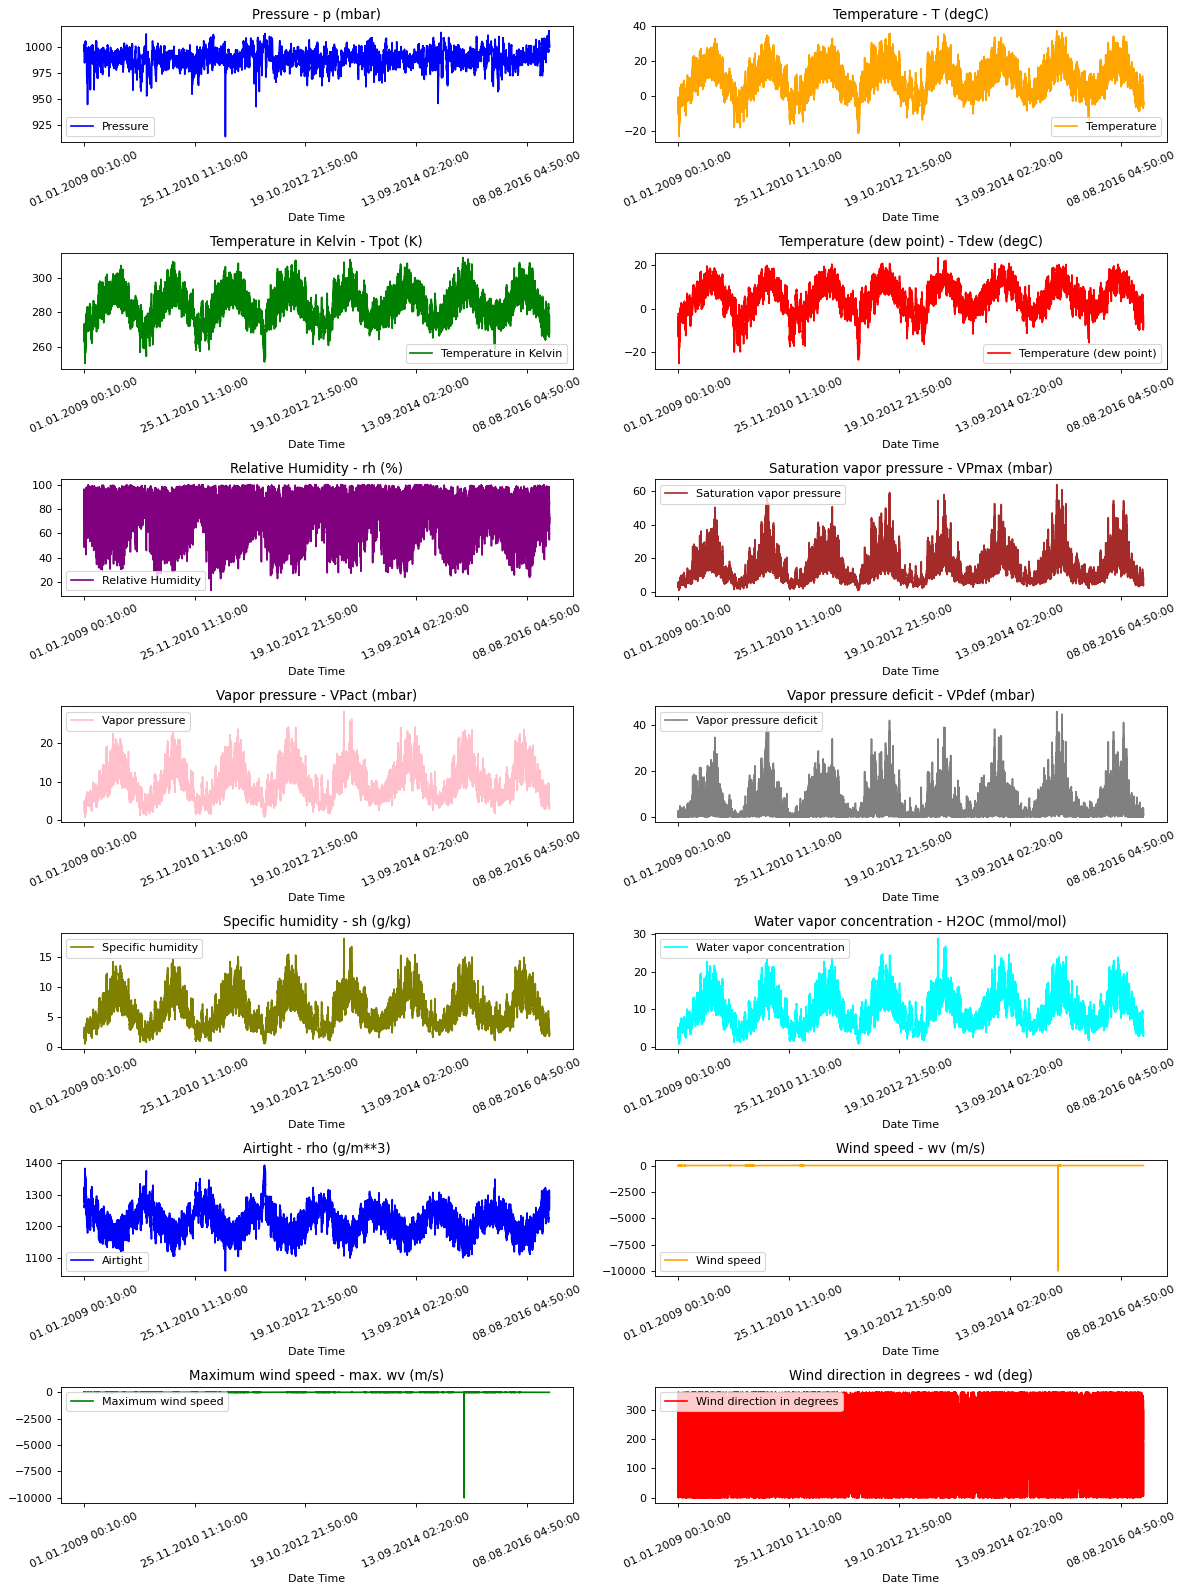

In [6]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "Date Time"


def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(   #it returns a tuple (fig, ax), giving a single figure "fig" with an array of axes "ax"
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(df)

<h3><span style="color: #00ff00;">This heat map shows the correlation between different features</span></h3>

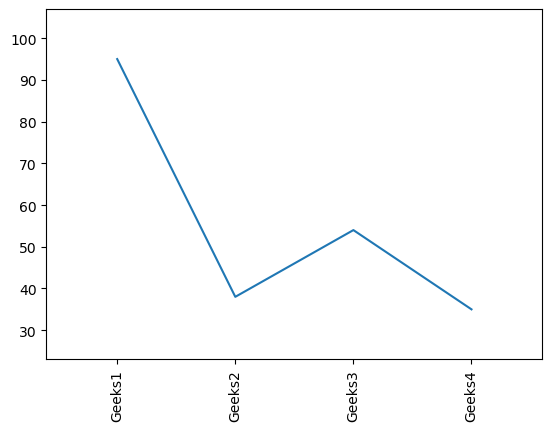

In [7]:
# Implementation of matplotlib.pyplot.xticks()
# function

import numpy as np
import matplotlib.pyplot as plt
	
xt = [1, 2, 3, 4]
yt = [95, 38, 54, 35]
labelst = ['Geeks1', 'Geeks2', 'Geeks3', 'Geeks4']

plt.plot(xt, yt)

# You can specify a rotation for the tick
# labels in degrees or with keywords.
plt.xticks(xt, labelst, rotation ='vertical')

# Pad margins so that markers don't get
# clipped by the axes
plt.margins(0.2)

# Tweak spacing to prevent clipping of tick-labels
plt.subplots_adjust(bottom = 0.15)
plt.show()


<p><span style="color: #00ff00;">matplotlib.pyplot.gca():</span></p>
<ul>
<li><span style="color: #00ff00;">Get the current Axes.</span></li>
</ul>
<p><span style="color: #00ff00;"><span class="sig-prename descclassname"><span class="pre">XAxis.</span></span><span class="sig-name descname"><span class="pre">tick_bottom</span></span><span class="sig-paren">(</span><span class="sig-paren">):</span></span></p>
<ul>
<li><span class="sig-paren" style="color: #00ff00;">Move ticks and ticklabels (if present) to the bottom of the Axes</span></li>
</ul>

In [8]:
df.corr()

C:\Users\Mahdi\AppData\Local\Temp\ipykernel_2500\1134722465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
p (mbar),1.000000,-0.045375,-0.124718,-0.066755,-0.018352,-0.031546,-0.054370,-0.003401,-0.069762,-0.069804,0.307640,-0.005701,-0.007760,-0.063258
T (degC),-0.045375,1.000000,0.996827,0.895708,-0.572416,0.951113,0.867673,0.761744,0.866755,0.867177,-0.963410,-0.004689,-0.002871,0.038732
Tpot (K),-0.124718,0.996827,1.000000,0.894911,-0.567127,0.947293,0.866205,0.756962,0.866533,0.866955,-0.981345,-0.004195,-0.002224,0.043599
Tdew (degC),-0.066755,0.895708,0.894911,1.000000,-0.156615,0.799271,0.968344,0.435752,0.967599,0.968044,-0.885232,-0.008718,-0.009091,0.049877
rh (%),-0.018352,-0.572416,-0.567127,-0.156615,1.000000,-0.615842,-0.151494,-0.843835,-0.150841,-0.150969,0.514282,-0.005020,-0.009921,-0.015912
VPmax (mbar),-0.031546,0.951113,0.947293,0.799271,-0.615842,1.000000,0.824865,0.875588,0.824460,0.824493,-0.901536,-0.004018,-0.002213,-0.009583
VPact (mbar),-0.054370,0.867673,0.866205,0.968344,-0.151494,0.824865,1.000000,0.449154,0.999851,0.999856,-0.850241,-0.009600,-0.010316,0.018418
VPdef (mbar),-0.003401,0.761744,0.756962,0.435752,-0.843835,0.875588,0.449154,1.000000,0.448641,0.448689,-0.698290,0.001852,0.005317,-0.030881
sh (g/kg),-0.069762,0.866755,0.866533,0.967599,-0.150841,0.824460,0.999851,0.448641,1.000000,0.999997,-0.853325,-0.009479,-0.010163,0.019376
H2OC (mmol/mol),-0.069804,0.867177,0.866955,0.968044,-0.150969,0.824493,0.999856,0.448689,0.999997,1.000000,-0.853769,-0.009477,-0.010158,0.019607


C:\Users\Mahdi\AppData\Local\Temp\ipykernel_2500\495170449.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.matshow(data.corr())


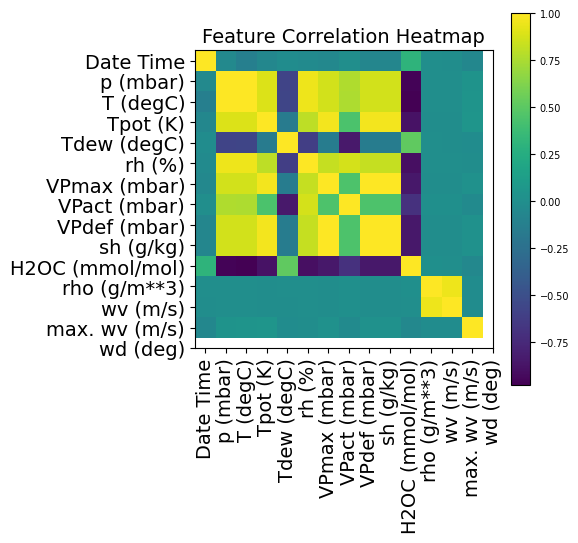

In [9]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)    #ticks(first passed parameter): This parameter is the list of xtick locations 
                                                                        #labels(second passed parameter): This parameter contains labels to place at the given ticks locations
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar() #Add a colorbar to a plot
    cb.ax.tick_params(labelsize=7)  #Axes.tick_params:Change the appearance of ticks, tick labels, and gridlines
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(df)

<p><span style="color: #00ff00;">Here we are picking ~300,000 data points for training. Observation is recorded every 10 mins, that means 6 times per hour. We will resample one point per hour since no drastic change is expected within 60 minutes. We do this via the sampling_rate argument in timeseries_dataset_from_array utility. We are tracking data from past 720 timestamps (720/6=120 hours). This data will be used to predict the temperature after 12 timestamps (12/6=2 hours). Since every feature has values with varying ranges, we do normalization to confine feature values to a range of [0, 1] before training a neural network. We do this by subtracting the mean and dividing by the standard deviation of each feature. 71.5 % of the data will be used to train the model, i.e. 300,693 rows. split_fraction can be changed to alter this percentage. The model is shown data for first 5 days i.e. 720 observations, that are sampled every hour. The temperature after 12 (2 hours * 6 observation per hour) observation will be used as a label.</span></p>

In [10]:
split_fraction = 0.715
train_split = int(split_fraction * int(df.shape[0]))
step = 3

past = 720
future = 12
learning_rate = 0.001
batch_size = 256
epochs = 10


def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

<p><span style="color: #00ff00;">We can see from the correlation heatmap, few parameters like Relative Humidity and Specific Humidity are redundant. Hence we will be using select features, not all.</span></p>

In [11]:
print(
    "The selected parameters are:",
    ", ".join([titles[i] for i in [0, 1, 5, 7, 8, 10, 11]]),
)


The selected parameters are: Pressure, Temperature, Saturation vapor pressure, Vapor pressure deficit, Specific humidity, Airtight, Wind speed


In [12]:
selected_features = [feature_keys[i] for i in [0, 1, 5, 7, 8, 10, 11]]
selected_features


['p (mbar)',
 'T (degC)',
 'VPmax (mbar)',
 'VPdef (mbar)',
 'sh (g/kg)',
 'rho (g/m**3)',
 'wv (m/s)']

In [13]:

features = df[selected_features]    #selected_features is a list
print(type(features))   #features is a dataframe
features



<class 'pandas.core.frame.DataFrame'>


,p (mbar),T (degC),VPmax (mbar),VPdef (mbar),sh (g/kg),rho (g/m**3),wv (m/s)
0,996.52,-8.02,3.33,0.22,1.94,1307.75,1.03
1,996.57,-8.41,3.23,0.21,1.89,1309.80,0.72
2,996.53,-8.51,3.21,0.20,1.88,1310.24,0.19
3,996.51,-8.31,3.26,0.19,1.92,1309.19,0.34
4,996.51,-8.27,3.27,0.19,1.92,1309.00,0.32
...,...,...,...,...,...,...,...
420546,1000.07,-4.05,4.52,1.22,2.06,1292.98,0.67
420547,999.93,-3.35,4.77,1.44,2.07,1289.44,1.14
420548,999.82,-3.16,4.84,1.55,2.05,1288.39,1.08
420549,999.81,-4.23,4.46,1.26,1.99,1293.56,1.49


In [14]:
features.index = df[date_time_key]  #DataFrame.index:The index (row labels) of the DataFrame,The row labels, called dataframe index, can be integer numbers or string values
features.head()


,p (mbar),T (degC),VPmax (mbar),VPdef (mbar),sh (g/kg),rho (g/m**3),wv (m/s)
Date Time,,,,,,,
01.01.2009 00:10:00,996.52,-8.02,3.33,0.22,1.94,1307.75,1.03
01.01.2009 00:20:00,996.57,-8.41,3.23,0.21,1.89,1309.80,0.72
01.01.2009 00:30:00,996.53,-8.51,3.21,0.20,1.88,1310.24,0.19
01.01.2009 00:40:00,996.51,-8.31,3.26,0.19,1.92,1309.19,0.34
01.01.2009 00:50:00,996.51,-8.27,3.27,0.19,1.92,1309.00,0.32


In [15]:

features = normalize(features.values, train_split)  #normalize returnes an ndarray
print(type(features))
features = pd.DataFrame(features)   #to convert the features to dataframe
print(type(features))
features.head()


<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>


,0,1,2,3,4,5,6
0,0.955451,-2.000020,-1.319782,-0.788479,-1.500927,2.237658,-0.732997
1,0.961528,-2.045185,-1.332806,-0.790561,-1.519521,2.287838,-0.936002
2,0.956666,-2.056766,-1.335410,-0.792642,-1.523239,2.298608,-1.283076
3,0.954236,-2.033604,-1.328898,-0.794724,-1.508364,2.272906,-1.184847
4,0.954236,-2.028972,-1.327596,-0.794724,-1.508364,2.268256,-1.197944


In [16]:

train_data = features.loc[:train_split-1]   #DataFrame.loc:Access a group of rows and columns by label(s) or a boolean array
val_data = features.loc[train_split:]
print(type(train_data))

<class 'pandas.core.frame.DataFrame'>


<h1 class="text-cell-section-header"><span style="color: #ffff99;">Training dataset</span></h1>
<p><span style="color: #ffff99;">The training dataset labels starts from the 792nd observation (720 + 72)</span></p>

In [17]:
a=[[1,2,3],[4,5,6],[7,8,9]] #1,2,3 in a row, 4,5,6 in the second row,...
a

[[1, 2, 3], [4, 5, 6], [7, 8, 9]]

In [18]:
adf=pd.DataFrame(a)
adf

,0,1,2
0,1,2,3
1,4,5,6
2,7,8,9


In [19]:
adf.iloc[1, 2]

6

In [20]:
b=adf.iloc[[0, 2]]  #to access more than one rows ,b is still a datraframe
print(type(b))
b

<class 'pandas.core.frame.DataFrame'>


,0,1,2
0,1,2,3
2,7,8,9


In [21]:
c=adf.iloc[[0, 2], [0, 1]]   #including rows and columns together
print(type(c))  # c is dataframe
c

<class 'pandas.core.frame.DataFrame'>


,0,1
0,1,2
2,7,8


In [22]:
adf.iloc[0:2]   #just first two rows

,0,1,2
0,1,2,3
1,4,5,6


In [23]:
d=adf.iloc[0:2][1]
print(type(d))
print(d)
ddf=adf.iloc[0:2][[1]]  #now this returnes dataframe
print(type(ddf))
print(ddf)

<class 'pandas.core.series.Series'>
0    2
1    5
Name: 1, dtype: int64
<class 'pandas.core.frame.DataFrame'>
   1
0  2
1  5


In [24]:
start = past + future   #past = 720 ,future = 12 in markdown it's been 72
end = start + train_split

x_train = train_data[[i for i in range(7)]].values  #as train_data is a dataframe in this way we pick its values
x_train


array([[ 0.95545114, -2.00002   , -1.31978162, ..., -1.50092673,
         2.23765845, -0.73299722],
       [ 0.96152792, -2.04518494, -1.33280552, ..., -1.51952063,
         2.28783773, -0.93600233],
       [ 0.9566665 , -2.0567657 , -1.3354103 , ..., -1.52323941,
         2.29860792, -1.28307559],
       ...,
       [-0.11163086,  0.90211719,  0.78097422, ...,  1.39228456,
        -0.92045437, -0.79193419],
       [-0.11770764,  0.89632681,  0.77185748, ...,  1.38856578,
        -0.91653794, -0.79193419],
       [-0.11041551,  0.8639007 ,  0.72757621, ...,  1.39600334,
        -0.88740948, -0.8312255 ]])

In [25]:
y_train = features.iloc[start:end][[1]] #returnes dataframe built from features rows from start to end and second column(temperature),1 should be enclosed by [] to mean column

sequence_length = int(past / step)

<h1 class="devsite-page-title"><span style="color: #ffff99;">tf.keras.preprocessing.timeseries_dataset_from_array</span></h1>
<ul>
<li><span style="color: #ffff99;">https://docs.w3cub.com/tensorflow~2.3/keras/preprocessing/timeseries_dataset_from_array 
Creates a dataset of sliding windows over a timeseries provided as array</span></li>
<li>
<pre class="devsite-click-to-copy prettyprint tfo-signature-link language-cpp language-py" dir="ltr" translate="no" data-language="cpp"><span style="color: #ffff99;">tf<span class="token punctuation">.</span>keras<span class="token punctuation">.</span>preprocessing<span class="token punctuation">.</span>timeseries_dataset_from_array<span class="token punctuation">(</span>
    data<span class="token punctuation">,</span> targets<span class="token punctuation">,</span> sequence_length<span class="token punctuation">,</span> sequence_stride<span class="token operator">=</span><span class="token number">1</span><span class="token punctuation">,</span> sampling_rate<span class="token operator">=</span><span class="token number">1</span><span class="token punctuation">,</span>
    batch_size<span class="token operator">=</span><span class="token number">128</span><span class="token punctuation">,</span> shuffle<span class="token operator">=</span><span class="token boolean">False</span><span class="token punctuation">,</span> seed<span class="token operator">=</span><span class="token boolean">None</span><span class="token punctuation">,</span> start_index<span class="token operator">=</span><span class="token boolean">None</span><span class="token punctuation">,</span> end_index<span class="token operator">=</span><span class="token boolean">None</span>
<span class="token punctuation">)</span></span></pre>
</li>
<li><span style="color: #ffff99;"><span class="token punctuation">The&nbsp;<code>timeseries_dataset_from_array</code>&nbsp;function takes in a sequence of data-points gathered at equal intervals, along with time series parameters such as length of the sequences/windows, spacing between two sequence/windows, etc., to produce batches of sub-timeseries inputs and targets sampled from the main timeseries.</span></span></li>
</ul>

<ul>
<li>
<table class="responsive fixed orange">
<tbody>
<tr>
<td><span style="color: #00ffff;"><code dir="ltr" translate="no">data</code></span></td>
<td><span style="color: #00ffff;">Numpy array or eager tensor containing consecutive data points (timesteps). Axis 0 is expected to be the time dimension.</span></td>
</tr>
<tr>
<td><span style="color: #00ffff;"><code dir="ltr" translate="no">targets</code></span></td>
<td><span style="color: #00ffff;">Targets corresponding to timesteps in&nbsp;<code dir="ltr" translate="no">data</code>. It should have same length as&nbsp;<code dir="ltr" translate="no">data</code>.&nbsp;<code dir="ltr" translate="no">targets[i]</code>&nbsp;should be the target corresponding to the window that starts at index&nbsp;<code dir="ltr" translate="no">i</code>&nbsp;(see example 2 below). Pass None if you don't have target data (in this case the dataset will only yield the input data).</span></td>
</tr>
<tr>
<td><span style="color: #00ffff;"><code dir="ltr" translate="no">sequence_length</code></span></td>
<td><span style="color: #00ffff;">Length of the output sequences (in number of timesteps).</span></td>
</tr>
<tr>
<td><span style="color: #00ffff;"><code dir="ltr" translate="no">sequence_stride</code></span></td>
<td><span style="color: #00ffff;">Period between successive output sequences. For stride&nbsp;<code dir="ltr" translate="no">s</code>, output samples would start at index&nbsp;<code dir="ltr" translate="no">data[i]</code>,&nbsp;<code dir="ltr" translate="no">data[i + s]</code>,&nbsp;<code dir="ltr" translate="no">data[i + 2 * s]</code>, etc.</span></td>
</tr>
<tr>
<td><span style="color: #00ffff;"><code dir="ltr" translate="no">sampling_rate</code></span></td>
<td><span style="color: #00ffff;">Period between successive individual timesteps within sequences. For rate&nbsp;<code dir="ltr" translate="no">r</code>, timesteps&nbsp;<code dir="ltr" translate="no">data[i], data[i + r], ... data[i + sequence_length]</code>&nbsp;are used for create a sample sequence.</span></td>
</tr>
<tr>
<td><span style="color: #00ffff;"><code dir="ltr" translate="no">batch_size</code></span></td>
<td><span style="color: #00ffff;">Number of timeseries samples in each batch (except maybe the last one).</span></td>
</tr>
<tr>
<td><span style="color: #00ffff;"><code dir="ltr" translate="no">shuffle</code></span></td>
<td><span style="color: #00ffff;">Whether to shuffle output samples, or instead draw them in chronological order.</span></td>
</tr>
<tr>
<td><span style="color: #00ffff;"><code dir="ltr" translate="no">seed</code></span></td>
<td><span style="color: #00ffff;">Optional int; random seed for shuffling</span></td>
</tr>
</tbody>
</table>
</li>
</ul>

<p><span style="color: #ffcc00;">Consider indices&nbsp;<code dir="ltr" translate="no">[0, 1, ... 99]</code>. With&nbsp;<code dir="ltr" translate="no">sequence_length=10, sampling_rate=2, sequence_stride=3</code>,&nbsp;<code dir="ltr" translate="no">shuffle=False</code>, the dataset will yield batches of sequences composed of the following indices:</span></p>
<pre class="prettyprint  language-cpp" dir="ltr" translate="no" data-language="cpp"><span style="color: #ffcc00;">First sequence<span class="token operator">:</span>  <span class="token punctuation">[</span><span class="token number">0</span>  <span class="token number">2</span>  <span class="token number">4</span>  <span class="token number">6</span>  <span class="token number">8</span> <span class="token number">10</span> <span class="token number">12</span> <span class="token number">14</span> <span class="token number">16</span> <span class="token number">18</span><span class="token punctuation">]</span>
Second sequence<span class="token operator">:</span> <span class="token punctuation">[</span><span class="token number">3</span>  <span class="token number">5</span>  <span class="token number">7</span>  <span class="token number">9</span> <span class="token number">11</span> <span class="token number">13</span> <span class="token number">15</span> <span class="token number">17</span> <span class="token number">19</span> <span class="token number">21</span><span class="token punctuation">]</span>
Third sequence<span class="token operator">:</span>  <span class="token punctuation">[</span><span class="token number">6</span>  <span class="token number">8</span> <span class="token number">10</span> <span class="token number">12</span> <span class="token number">14</span> <span class="token number">16</span> <span class="token number">18</span> <span class="token number">20</span> <span class="token number">22</span> <span class="token number">24</span><span class="token punctuation">]</span>
<span class="token punctuation">.</span><span class="token punctuation">.</span><span class="token punctuation">.</span>
Last sequence<span class="token operator">:</span>   <span class="token punctuation">[</span><span class="token number">78</span> <span class="token number">80</span> <span class="token number">82</span> <span class="token number">84</span> <span class="token number">86</span> <span class="token number">88</span> <span class="token number">90</span> <span class="token number">92</span> <span class="token number">94</span> <span class="token number">96</span><span class="token punctuation">]</span>
</span></pre>
<p><span style="color: #ffcc00;">In this case the last 3 data points are discarded since no full sequence can be generated to include them (the next sequence would have started at index 81, and thus its last step would have gone over 99).</span></p>

<table class="responsive fixed orange">
<tbody>
<tr>
<th style="text-align: left;" colspan="2"><span style="color: #ffff99;">Returns</span></th>
</tr>
<tr class="alt">
<td colspan="2"><span style="color: #ffff99;">A tf.data.Dataset instance. If&nbsp;<span style="color: #99ccff;"><code dir="ltr" translate="no">targets</code></span>&nbsp;was passed, the dataset yields tuple&nbsp;<code dir="ltr" translate="no"><span style="color: #99ccff;">(batch_of_sequences, batch_of_targets)</span></code>. If not, the dataset yields only&nbsp;<span style="color: #99ccff;"><code dir="ltr" translate="no">batch_of_sequences</code></span></span></td>
</tr>
</tbody>
</table>

<p><span style="color: #ffff99;">dataset <span class="token operator">=</span> tf<span class="token punctuation">.</span>keras<span class="token punctuation">.</span>preprocessing<span class="token punctuation">.</span>timeseries_dataset_from_array<span class="token punctuation">(</span> input_data<span class="token punctuation">,</span> targets<span class="token punctuation">,</span> sequence_length<span class="token operator">=</span><span class="token number">10</span><span class="token punctuation">)</span></span></p>
<p><span style="color: #ffff99;"> <span class="token keyword">for</span> batch <span class="token keyword">in</span> dataset<span class="token punctuation">:</span> </span></p>
<p><span style="color: #ffff99;">&nbsp; &nbsp; &nbsp; &nbsp;inputs<span class="token punctuation">,</span> targets <span class="token operator">=</span> batch</span></p>

In [26]:
print(x_train.shape)
print(y_train.shape)

(300693, 7)
(300693, 1)


In [27]:
print(sequence_length,batch_size,step)

240 256 3


In [28]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,    #240
    sampling_rate=step, #3
    batch_size=batch_size,  #256
)

<p><span style="color: #ffff99;">dataset_train:consists of 1172(300693 train timepoints / 256 size of batch) batches,samples are equal to timepoints as stride is 1 and for every sample sampling rate is 3</span></p>


In [29]:
a=0
for batch in dataset_train: 
    bat=batch   #first element of bat is batch of data,every batch is 256 long but for the last one the patch is incomplete=300693-(1171*256)-720=198   #every 198 timestamps 
    a+=1                                                                                                                                           #corresponding to a sequence
print(bat)  #this is last output tuple consisting of 
                        # 1)a batch including 198 sequences each of which consists of 240 timepoints with 7 features  2)those samples target labels 
                        # look at next cell comments
print(a)    #a becomes 1172 counting all batches

(<tf.Tensor: shape=(198, 240, 7), dtype=float64, numpy=
array([[[ 0.18856191,  0.57901413,  0.36551166, ...,  0.81959235,
         -0.54007092,  1.06130606],
        [ 0.19828475,  0.53848148,  0.31732321, ...,  0.82331113,
         -0.50237526,  1.45421918],
        [ 0.20557689,  0.57901413,  0.36551166, ...,  0.91999943,
         -0.54080525,  1.42147642],
        ...,
        [ 0.31009745,  1.43483192,  1.62101607, ...,  1.9389453 ,
         -1.29618706, -0.57583197],
        [ 0.29308247,  1.50779067,  1.75255751, ...,  1.70466213,
         -1.350038  ,  0.06592614],
        [ 0.28457498,  1.53905871,  1.81116508, ...,  1.40715968,
         -1.36423507,  1.33634524]],

       [[ 0.19099262,  0.55469454,  0.33685907, ...,  0.76009186,
         -0.51559322,  1.369088  ],
        [ 0.20436153,  0.53384918,  0.31211365, ...,  0.87537406,
         -0.49943794,  1.54589891],
        [ 0.20557689,  0.63112752,  0.4280264 , ...,  0.94231211,
         -0.58755765,  1.17917999],
        ...

In [30]:
a=0
for batch in dataset_train:
    bat=batch
    a+=1
    break
print(bat)  #this tuple is the same as next cell tuple,meaning that take(1) returnes the first tuple of dataset_train
print(bat[0].shape) #the batch is complete and 256 long
print(bat[1].shape) #bat is a tuple consisting of just two elements then next line of code retunes an error
# print(bat[2].shape)   
print(a)

(<tf.Tensor: shape=(256, 240, 7), dtype=float64, numpy=
array([[[ 0.95545114, -2.00002   , -1.31978162, ..., -1.50092673,
          2.23765845, -0.73299722],
        [ 0.95423578, -2.03360419, -1.32889835, ..., -1.50836429,
          2.27290634, -1.18484731],
        [ 0.95302043, -1.95369698, -1.30545532, ..., -1.46373892,
          2.18698961, -1.28962415],
        ...,
        [ 1.02715711, -2.38218491, -1.42006568, ..., -1.75752259,
          2.67434061,  0.87139804],
        [ 1.06483312, -2.45630174, -1.43569437, ..., -1.77239771,
          2.76441855, -0.01920504],
        [ 1.07455597, -2.51073129, -1.44871827, ..., -1.77983527,
          2.82610235, -0.60857473]],

       [[ 0.96152792, -2.04518494, -1.33280552, ..., -1.51952063,
          2.28783773, -0.93600233],
        [ 0.95423578, -2.02897188, -1.32759596, ..., -1.50836429,
          2.26825557, -1.19794442],
        [ 0.95302043, -1.95369698, -1.30545532, ..., -1.4674577 ,
          2.18723439, -1.28307559],
        ...

In [31]:
a=0
for batch in dataset_train.take(1):
    bat=batch
    a+=1
print(bat)
print(a)

(<tf.Tensor: shape=(256, 240, 7), dtype=float64, numpy=
array([[[ 0.95545114, -2.00002   , -1.31978162, ..., -1.50092673,
          2.23765845, -0.73299722],
        [ 0.95423578, -2.03360419, -1.32889835, ..., -1.50836429,
          2.27290634, -1.18484731],
        [ 0.95302043, -1.95369698, -1.30545532, ..., -1.46373892,
          2.18698961, -1.28962415],
        ...,
        [ 1.02715711, -2.38218491, -1.42006568, ..., -1.75752259,
          2.67434061,  0.87139804],
        [ 1.06483312, -2.45630174, -1.43569437, ..., -1.77239771,
          2.76441855, -0.01920504],
        [ 1.07455597, -2.51073129, -1.44871827, ..., -1.77983527,
          2.82610235, -0.60857473]],

       [[ 0.96152792, -2.04518494, -1.33280552, ..., -1.51952063,
          2.28783773, -0.93600233],
        [ 0.95423578, -2.02897188, -1.32759596, ..., -1.50836429,
          2.26825557, -1.19794442],
        [ 0.95302043, -1.95369698, -1.30545532, ..., -1.4674577 ,
          2.18723439, -1.28307559],
        ...

In [32]:
a=0
for batch in dataset_train.take(5): #take 5 returnes 5 batches,each of which consists 256*240 timepoints each of which with 7 features
    bat=batch
    a+=1
print(bat)
print(a)

(<tf.Tensor: shape=(256, 240, 7), dtype=float64, numpy=
array([[[ 1.47683859, -2.54894778, -1.45653262, ..., -1.74264747,
          2.97370288, -1.21759007],
        [ 1.51694531, -2.58369005, -1.46304457, ..., -1.75752259,
          3.02314783, -1.02113351],
        [ 1.54611384, -2.55358008, -1.45783501, ..., -1.74264747,
          2.99769102, -0.49070079],
        ...,
        [ 0.50698501, -1.60743241, -1.18954257, ..., -1.55298966,
          1.71971032,  0.67494148],
        [ 0.45958616, -1.5842709 , -1.18172823, ..., -1.5455521 ,
          1.6837281 ,  0.39335374],
        [ 0.41826407, -1.61553893, -1.19344974, ..., -1.53811454,
          1.70379982,  0.68803859]],

       [[ 1.49749963, -2.57210929, -1.46043979, ..., -1.75008503,
          3.00503433, -1.32891546],
        [ 1.52788351, -2.58832235, -1.46434696, ..., -1.76124137,
          3.03147025, -1.03423061],
        [ 1.55583669, -2.49683438, -1.4448111 , ..., -1.72405356,
          2.93772066, -0.57583197],
        ...

In [33]:
a=0
for x,y in dataset_train.take(1): 
    # x[0][:, 1].numpy()
    a+=1
# print(bat)
print(x[0][:, 1].numpy().shape)
plot_data=x[0][:, 1].numpy()
print(type(plot_data))
print(plot_data[0])
# print(plot_data[0].shape[0])
# plot_data[0].shape[0]
x[0][:, 1].numpy()

(240,)
<class 'numpy.ndarray'>
-2.0000199972502597


array([-2.00002   , -2.03360419, -1.95369698, -2.04750109, -2.09614026,
       -2.07413683, -2.09498219, -2.09729834, -2.14014713, -2.15404404,
       -2.19110245, -2.21889627, -2.18183785, -2.1181437 , -2.07992721,
       -2.03244611, -2.0139169 , -1.96759388, -1.96411966, -1.89926743,
       -1.88537052, -1.92127086, -1.93748392, -1.9004255 , -1.85526056,
       -1.8251506 , -1.74640146, -1.76261452, -1.74755954, -1.73829494,
       -1.7116592 , -1.68733961, -1.68618154, -1.68386539, -1.70007844,
       -1.67460078, -1.66881041, -1.65143927, -1.63870044, -1.64680697,
       -1.64217467, -1.6502812 , -1.63175199, -1.62248739, -1.58195474,
       -1.55416093, -1.59237742, -1.57269014, -1.60395818, -1.5981678 ,
       -1.57963859, -1.57037399, -1.56458361, -1.57153206, -1.59237742,
       -1.57269014, -1.60743241, -1.63406814, -1.64333275, -1.60859048,
       -1.57848052, -1.55300286, -1.57384822, -1.5842709 , -1.57732244,
       -1.56226746, -1.54258018, -1.52289289, -1.53099942, -1.51

<h2 class="text-cell-section-header"><span style="color: #00ccff;">Validation dataset</span></h2>
<p><span style="color: #00ccff;">The validation dataset must not contain the last 792 rows as we won't have label data for those records, hence 792 must be subtracted from the end of the data.</span></p>
<p><span style="color: #00ccff;">The validation label dataset must start from 792 after train_split, hence we must add past + future (792) to label_start.</span></p>

In [34]:
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(7)]].values
y_val = features.iloc[label_start:][[1]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,    #the output sequence length no matter what the sampling rate,stride,... are. 
    sampling_rate=step,
    batch_size=batch_size,
)

for batch in dataset_train.take(1):
    inputs, targets = batch

print(type(inputs))
print(type(targets))

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
Input shape: (256, 240, 7)
Target shape: (256, 1)


In [35]:
print(len(dataset_train) * 256)
print(x_train.shape)
print(x_val.shape)

300032
(300693, 7)
(119126, 7)


<div class="wDYxhc NFQFxe viOShc LKPcQc" lang="en-IR" data-md="25">
<div class="HwtpBd gsrt PZPZlf kTOYnf" role="heading" aria-level="3" data-hveid="CBkQAA" data-ved="2ahUKEwif2czBtN7_AhW67rsIHXzjAe8QtwcoAHoECBkQAA">
<div class="Z0LcW AZCkJd d2J77b t2b5Cf" data-tts="answers" data-tts-text="Multilayer Perceptron">
<h3 class="IZ6rdc"><span style="color: #ffff99;">Multilayer Perceptron(MLP):</span></h3>
<p class="IZ6rdc"><span style="color: #ffff99;">A fully connected multi-layer neural network is called a&nbsp;<strong style="font-size: 14px;">Multilayer Perceptron</strong><span style="font-size: 14px;">&nbsp;(MLP). It has 3 layers including one hidden layer. If it has more than 1 hidden layer, it is called a deep ANN. An MLP is a typical example of a feedforward artificial neural network</span></span></p>
</div>
</div>
</div>

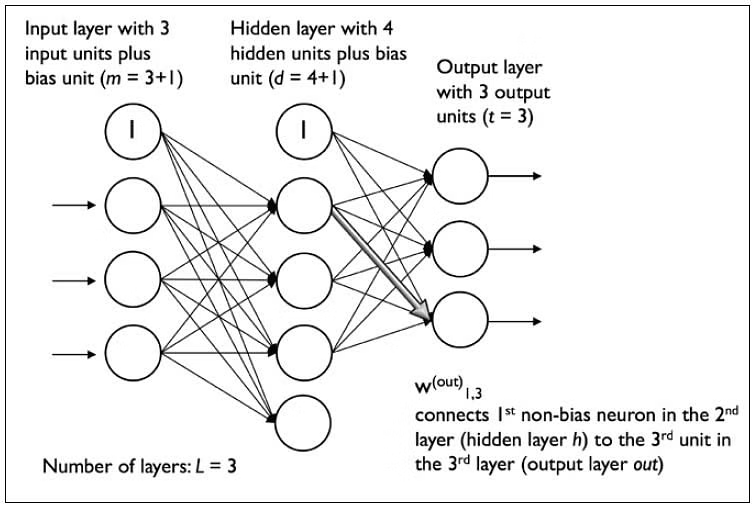

<p><span style="color: #ffff99;">first with dense layers...</span></p>

In [36]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
x = keras.layers.Flatten()(inputs)
h = keras.layers.Dense(64, activation='tanh')(x)
outputs = keras.layers.Dense(1)(h)  #by default the activation is linear

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse") #loss =mse as we don't want to classify and we want to regress the temp
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 7)]          0         
                                                                 
 flatten (Flatten)           (None, 1680)              0         
                                                                 
 dense (Dense)               (None, 64)                107584    
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 107,649
Trainable params: 107,649
Non-trainable params: 0
_________________________________________________________________


In [37]:
history = model.fit(
    dataset_train,  #arguments for model.fit:A tf.data dataset. Should return a tuple of either (inputs, targets) or (inputs, targets, sample_weights)
    epochs=epochs,
    validation_data=dataset_val)

Epoch 1/10
1172/1172 [==============================] - 42s 34ms/step - loss: 0.5270 - val_loss: 0.3531
Epoch 2/10
1172/1172 [==============================] - 40s 34ms/step - loss: 0.2783 - val_loss: 0.2574
Epoch 3/10
1172/1172 [==============================] - 43s 37ms/step - loss: 0.2168 - val_loss: 0.2316
Epoch 4/10
1172/1172 [==============================] - 39s 34ms/step - loss: 0.2147 - val_loss: 0.2445
Epoch 5/10
1172/1172 [==============================] - 41s 35ms/step - loss: 0.2012 - val_loss: 0.1861
Epoch 6/10
1172/1172 [==============================] - 39s 33ms/step - loss: 0.1902 - val_loss: 0.1857
Epoch 7/10
1172/1172 [==============================] - 39s 33ms/step - loss: 0.1769 - val_loss: 0.1707
Epoch 8/10
1172/1172 [==============================] - 41s 35ms/step - loss: 0.1636 - val_loss: 0.1555
Epoch 9/10
1172/1172 [==============================] - 39s 34ms/step - loss: 0.1433 - val_loss: 0.1502
Epoch 10/10
1172/1172 [==============================] - 40s 34m

<h4><span style="color: #ffff99;">Train a simple RNN model</span></h4>

In [38]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
rnn_out = keras.layers.SimpleRNN(64)(inputs)
outputs = keras.layers.Dense(1)(rnn_out)    #a 1-neuron dense layer without any activation meaning that its activation is linear for a value prediction

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary() #64*(64+7+1) parameters for rnn layer

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 7)]          0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                4608      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,673
Trainable params: 4,673
Non-trainable params: 0
_________________________________________________________________


https://neptune.ai/blog/tensorboard-tutorial

<p><span style="color: #ffff99;">This callback is responsible for logging events such as Activation Histograms, Metrics Summary Plots, Profiling and Training Graph Visualizations</span></p>

<p><span style="color: #ffcc00;">With that in place, you can now create the TensorBoard callback and specify the log directory using log_dir. The TensorBoard callback also takes other parameters:</span></p>
<ul>
<li><span style="color: #ffcc00;"> histogram_freq is the frequency at which to compute activation and weight histograms for layers of the model. Setting this to 0 means that histograms will not be computed. In order for this to work you have to set the validation data or the validation split.</span></li>
<li><span style="color: #ffcc00;"> write_graph dictates if the graph will be visualized in TensorBoard</span></li>
<li><span style="color: #ffcc00;"> write_images when set to true, model weights are visualized as an image in TensorBoard </span></li>
<li><span style="color: #ffcc00;">update_freq determines how losses and metrics are written to TensorBoard. When set to an integer, say 100, losses and metrics are logged every 100 batches. When set to batch the losses and metrics are set after every batch. When set to epoch they are written after every epoch </span></li>
<li><span style="color: #ffcc00;">profile_batch determines which batches will be profiled. By default, the second batch is profiled. You can also set, for example from 5 and to 10, to profile batches 5 to 10, i.e profile_batch=&rsquo;5,10&prime; . Setting profile_batch to 0 disables profiling. </span></li>
<li><span style="color: #ffcc00;">embeddings_freq the frequency at which the embedding layers will be visualized. Setting this to zero means that the embeddings will not be visualized</span></li>
</ul>

In [39]:
from tensorflow.keras.callbacks import TensorBoard

In [40]:
log_folder = 'logs'
# rm -rf logs #to clear the current logs so that you can write fresh ones to the folder

In [41]:
tensorboardcallbacks = TensorBoard(log_dir=log_folder,
                         histogram_freq=1,
                         write_graph=True,
                         write_images=True,
                         update_freq='epoch',
                         profile_batch=2,
                         embeddings_freq=1)

<p><span style="color: #ffff99;">We'll use the ModelCheckpoint callback to regularly save checkpoints, and the EarlyStopping callback to interrupt training when the validation loss is not longer improvin</span>g</p>

<h3><span style="color: #99ccff;">ModelCheckpoint:</span></h3>
<ul>
<li>
<p><span style="color: #99ccff;">Callback to save the Keras model or model weights at some frequency.</span></p>
<p><span style="color: #99ccff;"><code>ModelCheckpoint</code>&nbsp;callback is used in conjunction with training using&nbsp;<code>model.fit()</code>&nbsp;to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved</span></p>
</li>
<li>
<pre><span style="color: #99ccff;"><code><span class="n">tf</span><span class="o">.</span><span class="n">keras</span><span class="o">.</span><span class="n">callbacks</span><span class="o">.</span><span class="n">ModelCheckpoint</span><span class="p">(</span>
    <span class="n">filepath</span><span class="p">,</span>
    <span class="n">monitor</span><span class="p">:</span> <span class="nb">str</span> <span class="o">=</span> <span class="s2">"val_loss"</span><span class="p">,</span>
    <span class="n">verbose</span><span class="p">:</span> <span class="nb">int</span> <span class="o">=</span> <span class="mi">0</span><span class="p">,</span>
    <span class="n">save_best_only</span><span class="p">:</span> <span class="nb">bool</span> <span class="o">=</span> <span class="kc">False</span><span class="p">,</span>
    <span class="n">save_weights_only</span><span class="p">:</span> <span class="nb">bool</span> <span class="o">=</span> <span class="kc">False</span><span class="p">,</span>
    <span class="n">mode</span><span class="p">:</span> <span class="nb">str</span> <span class="o">=</span> <span class="s2">"auto"</span><span class="p">,</span>
    <span class="n">save_freq</span><span class="o">=</span><span class="s2">"epoch"</span><span class="p">,</span>
    <span class="n">options</span><span class="o">=</span><span class="kc">None</span><span class="p">,</span>
    <span class="n">initial_value_threshold</span><span class="o">=</span><span class="kc">None</span><span class="p">,</span>
    <span class="o">**</span><span class="n">kwargs</span>
<span class="p">)</span></code></span></pre>
</li>
<li><span style="color: #99ccff;">A few options this callback provides include:</span>
<ul>
<li><span style="color: #99ccff;">Whether to only keep the model that has achieved the "best performance" so far, or whether to save the model at the end of every epoch regardless of performance.</span></li>
<li><span style="color: #99ccff;">Definition of 'best'; which quantity to monitor and whether it should be maximized or minimized.</span></li>
<li><span style="color: #99ccff;">The frequency it should save at. Currently, the callback supports saving at the end of every epoch, or after a fixed number of training batches.</span></li>
<li><span style="color: #99ccff;">Whether only weights are saved, or the whole model is saved</span></li>
<li><span style="color: #99ccff;"><strong>save_best_only</strong>: if&nbsp;<code>save_best_only=True</code>, it only saves when the model is considered the "best" and the latest best model according to the quantity monitored will not be overwritten</span></li>
<li><span style="color: #99ccff;"><strong>monitor</strong>: The metric name to monitor</span></li>
<li><span style="color: #99ccff;"><strong>mode</strong>: one of {'auto', 'min', 'max'}. If&nbsp;<code>save_best_only=True</code>, the decision to overwrite the current save file is made based on either the maximization or the minimization of the monitored quantity. For&nbsp;<code>val_acc</code>, this should be&nbsp;<code>max</code>, for&nbsp;<code>val_loss</code>&nbsp;this should be&nbsp;<code>min</code>, etc. In&nbsp;<code>auto</code>&nbsp;mode, the mode is set to&nbsp;<code>max</code>&nbsp;if the quantities monitored are 'acc' or start with 'fmeasure' and are set to&nbsp;<code>min</code>&nbsp;for the rest of the quantities</span></li>
<li><span style="color: #99ccff;"><strong>save_weights_only</strong>: if True, then only the model's weights will be saved (<code>model.save_weights(filepath)</code>), else the full model is saved (<code>model.save(filepath)</code>).</span></li>
<li>
<pre>&nbsp;</pre>
</li>
</ul>
</li>
</ul>

In [42]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback,tensorboardcallbacks],
)

Epoch 1/10
1172/1172 [==============================] - ETA: 0s - loss: 0.0556
Epoch 1: val_loss improved from inf to 0.06483, saving model to model_checkpoint.h5
1172/1172 [==============================] - 146s 124ms/step - loss: 0.0556 - val_loss: 0.0648
Epoch 2/10
1172/1172 [==============================] - ETA: 0s - loss: 0.0427
Epoch 2: val_loss improved from 0.06483 to 0.06163, saving model to model_checkpoint.h5
1172/1172 [==============================] - 144s 123ms/step - loss: 0.0427 - val_loss: 0.0616
Epoch 3/10
1172/1172 [==============================] - ETA: 0s - loss: 0.0417
Epoch 3: val_loss improved from 0.06163 to 0.05545, saving model to model_checkpoint.h5
1172/1172 [==============================] - 144s 123ms/step - loss: 0.0417 - val_loss: 0.0554
Epoch 4/10
1172/1172 [==============================] - ETA: 0s - loss: 0.0419
Epoch 4: val_loss did not improve from 0.05545
1172/1172 [==============================] - 147s 125ms/step - loss: 0.0419 - val_loss: 0.06

In [43]:
print(type(history))
print(type(history.history))
history.history #is a dictionary with keys:'loss','val_loss' and their corresponding values related to every epoch

<class 'keras.callbacks.History'>
<class 'dict'>


{'loss': [0.05562584847211838,
  0.04274861514568329,
  0.041681110858917236,
  0.04189121350646019,
  0.041261229664087296,
  0.03930065408349037,
  0.039459679275751114,
  0.03920422121882439,
  0.03978702798485756,
  0.03943270817399025],
 'val_loss': [0.06483341753482819,
  0.061628587543964386,
  0.05544982850551605,
  0.06233164295554161,
  0.05477369949221611,
  0.0636640191078186,
  0.04670717939734459,
  0.06212690845131874,
  0.05988268926739693,
  0.05282721668481827]}

<h3><span style="color: #ffff99;">Using extensions:</span></h3>
<p><span style="color: #ffff99;"> To load an extension while IPython is running, use the %load_ext magic</span></p>

<h1 class="text-cell-section-header"><span style="color: #ff6600;">Compare Results:</span></h1>

<p><span style="color: #ffff99;">We can visualize the loss with the function below. After one point, the loss stops decreasing</span></p>

In [44]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()    #what is put at upper left of graph
    plt.show()

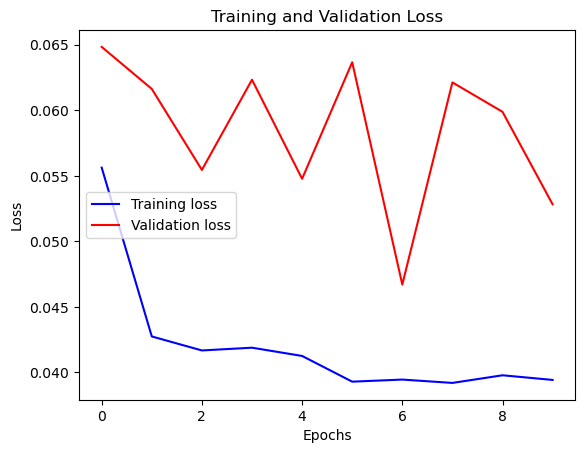

In [45]:
visualize_loss(history, "Training and Validation Loss")

<p><span style="color: #ffff99;">Both in Pytorch and Tensorflow, the&nbsp;<code>.numpy()</code>&nbsp;method is pretty much straightforward. It converts a&nbsp;<code>tensor</code>&nbsp;object into an&nbsp;<code>numpy.ndarray</code>&nbsp;object. This implicitly means that the converted tensor will be now processed on the CPU</span></p>

<h3><span style="color: #ffcc00;">Prediction: </span></h3>
<p><span style="color: #ffcc00;">The trained model above is now able to make predictions for 5 sets of values from validation set.</span></p>

8/8 [==============================] - 0s 11ms/step


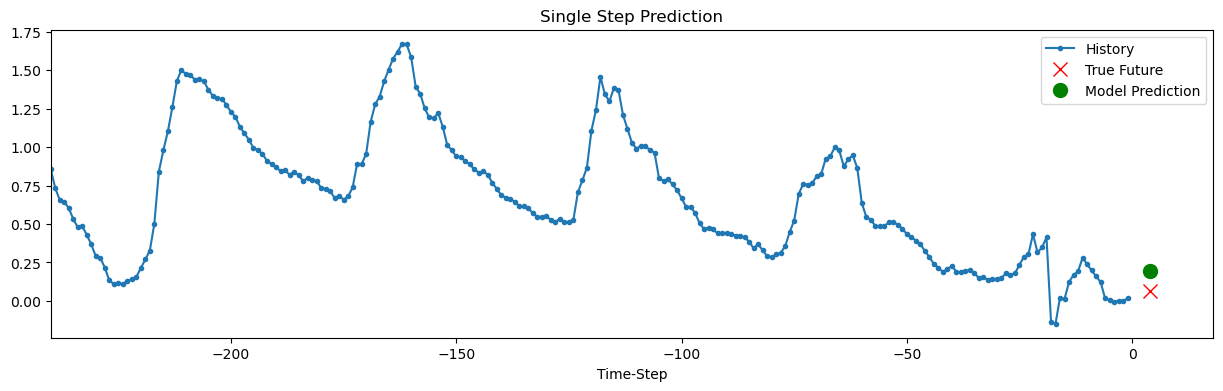

8/8 [==============================] - 0s 10ms/step


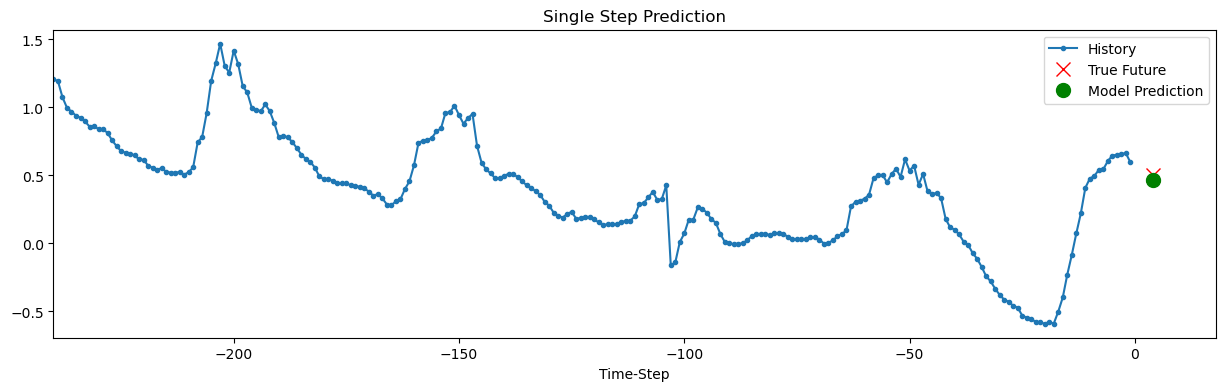

8/8 [==============================] - 0s 10ms/step


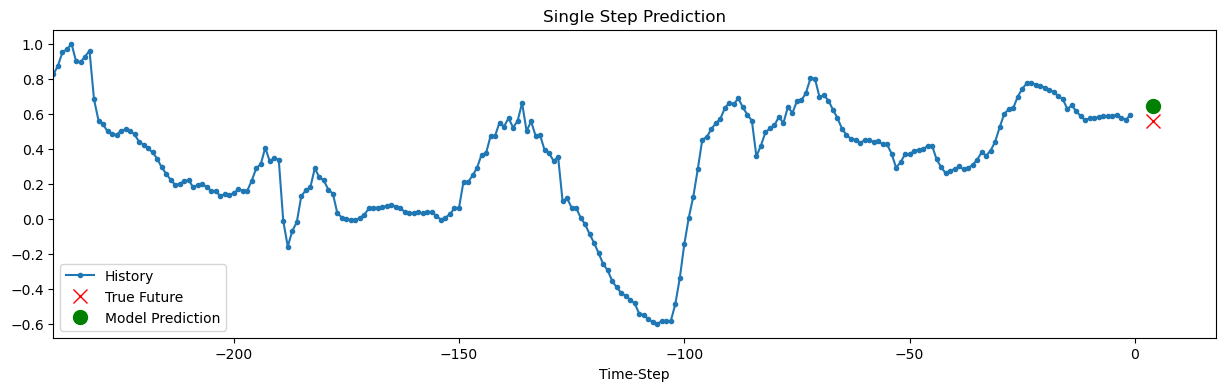

8/8 [==============================] - 0s 12ms/step


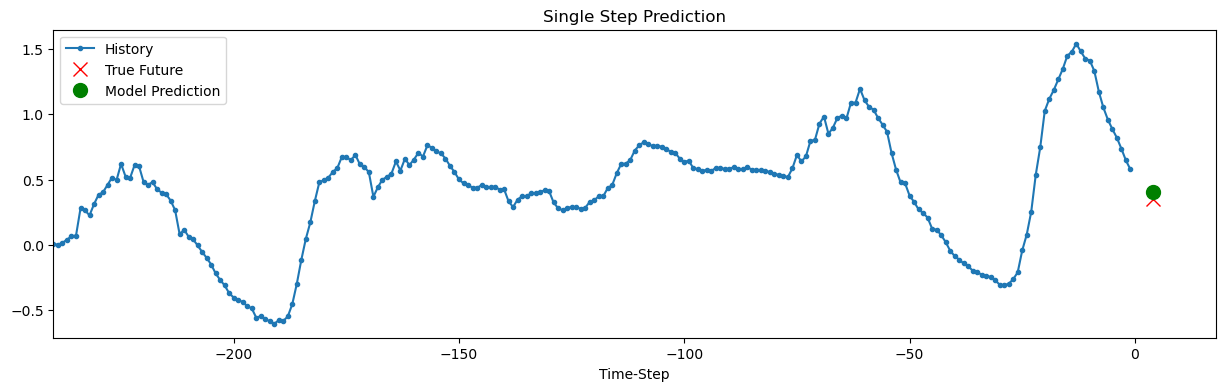

8/8 [==============================] - 0s 13ms/step


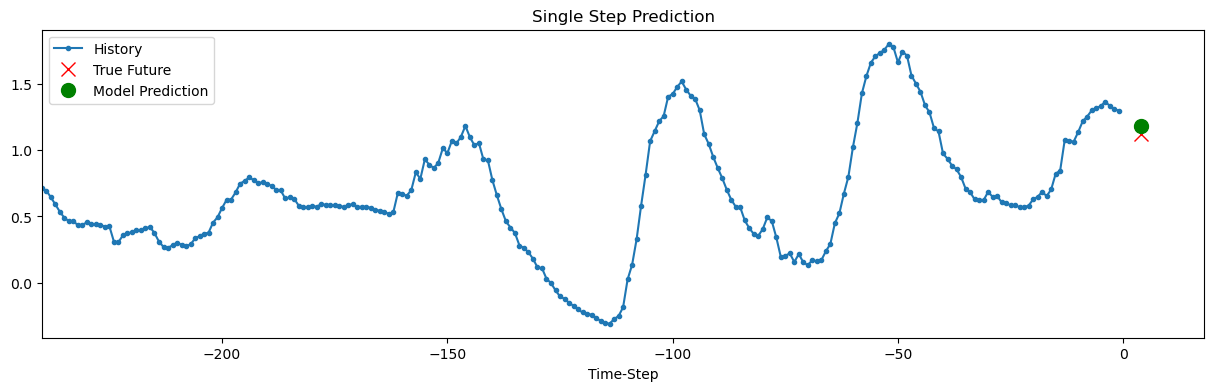

In [46]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))   #notice that a 3-item list is sent as plot_data then plot_data[0] is x[0][:, 1].numpy() meaning all 240 temp numbers
    if delta:                                               #plot_data[0].shape[0]=240
        future = delta
    else:
        future = 0

    plt.figure(figsize=(15, 4))
    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            # plt.plot(future, plot_data[i], marker[i], markersize=10, label="mehdi")
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i]) #label is what is written next to their marker in plot for example uncomment previous line
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])    #ndarray.flatten(order='C'):Return a copy of the array collapsed into one dimension
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):    #here we have 5 batches along with their values returned,x represents for every batch,y represents for their 256 values
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],    #x[0] means first sequence of 256-sequence batch,consisting of 240 timepoints,
        future//step,  # this is sent as delta                      #x[0][:, 1] first sequence but just their temp values
        "Single Step Prediction",
    )

In [47]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [2]:
# %tensorboard --logdir=logs
%tensorboard --logdir={log_folder}

UsageError: Line magic function `%tensorboard` not found.


<h2><span style="color: #ffff99;">GRU parameters number:</span></h2>

https://stats.stackexchange.com/questions/328926/how-many-parameters-are-in-a-gated-recurrent-unit-gru-recurrent-neural-network#:~:text=...%20the%20total%20number%20of,weight%20matrices%20of%20these%20sizes.

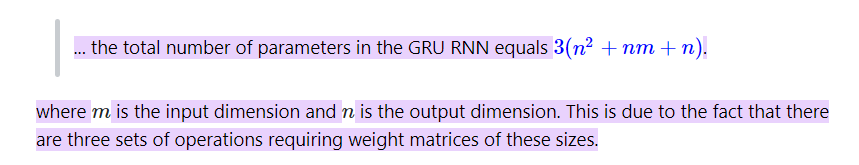
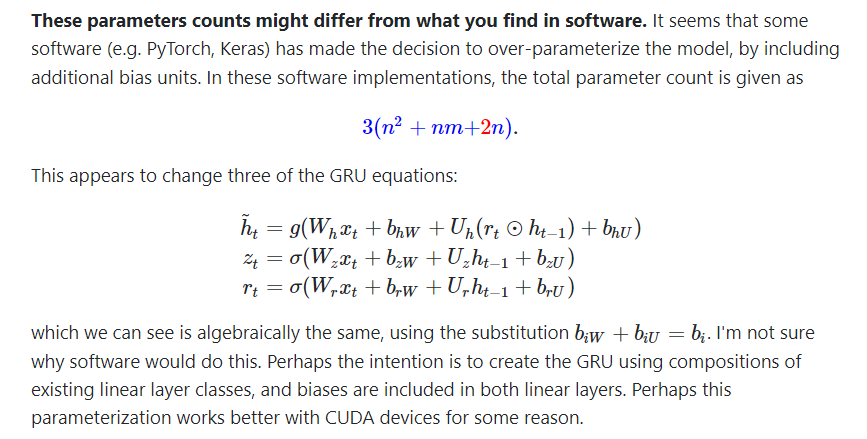
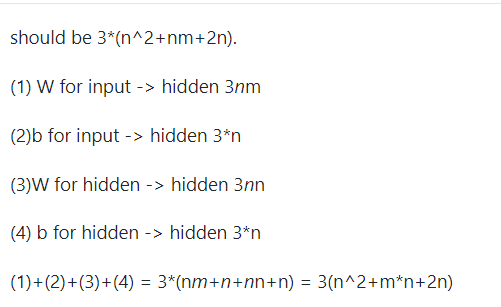

GRU parameters:m=input dimension=7,n=hidden layer size=64=>bias size for input=64,bias size for hidden layer=64 then no of parameters for GRU=3*(7*64+64*64+64+64)=14016

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 240, 7)]          0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                4608      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,673
Trainable params: 4,673
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1172/1172 [==============================] - 150s 127ms/step - loss: 0.2762 - val_loss: 0.2422
Epoch 2/10
1172/1172 [==============================] - 154s 132ms/step - loss: 0.2525 - val_loss: 0.2281
Epoch 3/10
1172/1172 [==============================] - 152s 130ms/step - loss: 0.2474 - val_loss: 0.2292
Epo

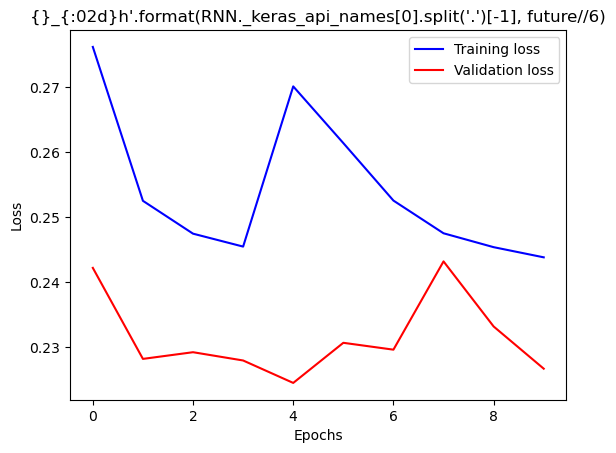

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 240, 7)]          0         
                                                                 
 gru (GRU)                   (None, 64)                14016     
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 14,081
Trainable params: 14,081
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1172/1172 [==============================] - 495s 420ms/step - loss: 0.2842 - val_loss: 0.2398
Epoch 2/10
1172/1172 [==============================] - 478s 408ms/step - loss: 0.2439 - val_loss: 0.2269
Epoch 3/10
1172/1172 [==============================] - 485s 414ms/step - loss: 0.2420 - val_loss: 0.2244
E

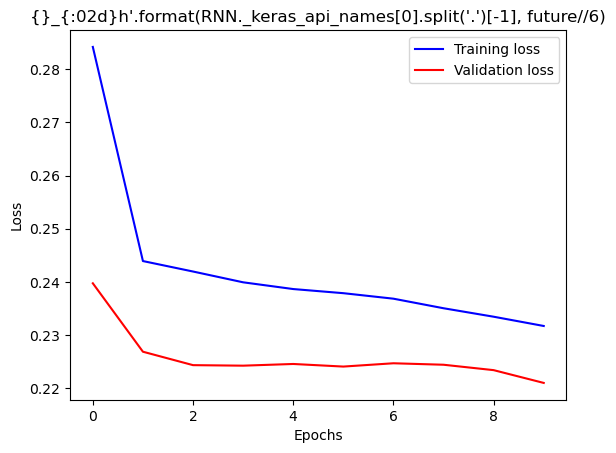

In [50]:
# for future in np.array([1, 6, 12, 48]) * 6:
for future in np.array([48]) * 6:
  # training dataset
  start = past + future
  end = start + train_split

  x_train = train_data[[i for i in range(7)]].values
  y_train = features.iloc[start:end][[1]]

  sequence_length = int(past / step)

  dataset_train = keras.preprocessing.timeseries_dataset_from_array(
      x_train,
      y_train,
      sequence_length=sequence_length,
      sampling_rate=step,
      batch_size=batch_size,
  )

  # validation dataset
  x_end = len(val_data) - past - future

  label_start = train_split + past + future

  x_val = val_data.iloc[:x_end][[i for i in range(7)]].values
  y_val = features.iloc[label_start:][[1]]

  dataset_val = keras.preprocessing.timeseries_dataset_from_array(
      x_val,
      y_val,
      sequence_length=sequence_length,
      sampling_rate=step,
      batch_size=batch_size,
  )

  for RNN in [keras.layers.SimpleRNN, keras.layers.GRU]:
    # define model
    inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
    rnn_out = RNN(64)(inputs)
    outputs = keras.layers.Dense(1)(rnn_out)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
    model.summary()

    # train model
    history = model.fit(
        dataset_train,
        epochs=epochs,
        validation_data=dataset_val,
        callbacks=[keras.callbacks.TensorBoard(log_dir='logs/{}_{:02d}h'.format(RNN._keras_api_names[0].split('.')[-1], future//6))],
    )

    visualize_loss(history, "{}_{:02d}h'.format(RNN._keras_api_names[0].split('.')[-1], future//6)")